In [264]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(420000)



class material:
    def __init__(self,name:str,sigma_a:float,sigma_s:float,sigma_f:float,nu:float):
        
        self.name=name
        self.sigma_a=sigma_a
        self.sigma_s=sigma_s
        self.sigma_f=sigma_f
        self.nu=nu

        self.sigma_t=self.sigma_a+self.sigma_f+sigma_s


class source:
    def __init__(self,type:str,r:float):
        self.r=r     



def sample_initial_neutrons(number_of_neutrons,source:object):
    """ 
    will accept the number of neutrons and send their sampled x,y position. 
    
    """
    x=np.random.uniform(-source.r,source.r,size=number_of_neutrons)*np.cos(np.random.uniform(0,np.pi*2,size=number_of_neutrons))
    y=np.random.uniform(-source.r,source.r,size=number_of_neutrons)*np.sin(np.random.uniform(0,np.pi*2,size=number_of_neutrons))

    return x,y 






In [265]:


X_left=-10
X_right=10

Y_up=10
Y_down=-10

Nx=1000
Ny=Nx

dx=(X_right-X_left)/Nx
dy=(Y_up-Y_down)/Ny

X = np.linspace(dx*0.5, (X_right-X_left) - 0.5*dx,Nx)
Y = np.linspace(dx*0.5, (Y_up-Y_down) - 0.5*dx,Ny)



In [266]:
uo2=material(name='fuel',sigma_a=0.2,sigma_f=.3,sigma_s=3,nu=2.5)
h20=material(name='coolant',sigma_a=.5,sigma_f=0,sigma_s=0.7,nu=0)

source=source(type='neutron',r=2)

fuel_rad=6

def find_mat(pos):

    x=pos[0]
    y=pos[1]
    
    if x**2+y**2<=fuel_rad:
        return uo2
    elif(x**2+y**2>fuel_rad) and abs(x)<=X_right and abs (y)<=Y_up :
        return h20
    else:
        return None
    
def find_surface_intersection_point(pos,pos_new):

    a=pos[0]
    b=pos[1]
    a_new=pos_new[0]
    b_new=pos_new[1]

    tol=1e-7

    for i in range (100):
        x=(a+a_new)/2
        y=(b+b_new)/2

        if abs(x**2+y**2-fuel_rad)<tol:
            break
        elif (x**2+y**2-fuel_rad)>0:
            a_new=x
            b_new=y
        elif (x**2+y**2-fuel_rad)<0:
            a=x
            b=y
    return x,y

In [267]:
active_batch=10
inactive_batch=5
no_of_gen_per_batch=1
number_of_neutrons=1000
N=number_of_neutrons

total_batch=active_batch+inactive_batch

scalar_flux = np.zeros((Nx,Ny))
scalar_flux_tl = np.zeros_like (scalar_flux)
collision_counter=np.zeros(((active_batch+inactive_batch),no_of_gen_per_batch,Nx,Ny))
weights=np.ones(number_of_neutrons)

In [268]:

x,y=sample_initial_neutrons(number_of_neutrons=number_of_neutrons,source=source)

(-10.0, 10.0)

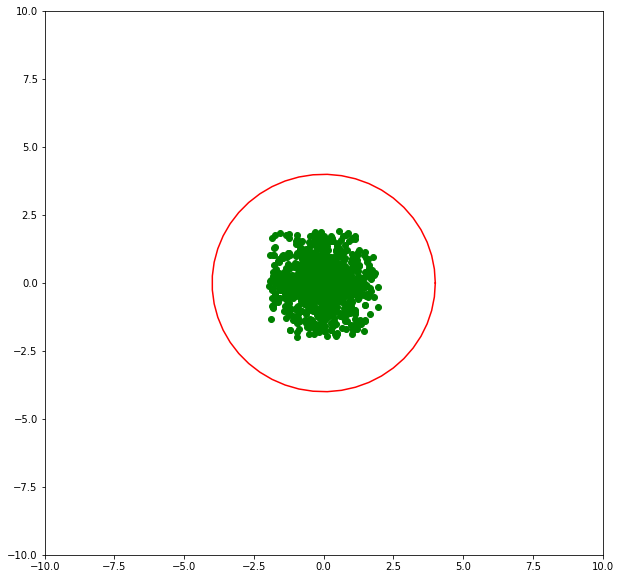

In [269]:
plt.figure(figsize=(10,10))
plt.scatter(x,y,color='g')
plt.plot(4*np.cos(np.linspace(0,np.pi*2)),4*np.sin(np.linspace(0,np.pi*2)),color='red')
plt.xlim(-10,10)
plt.ylim(-10,10)

In [270]:

fission_sites_x=np.array([])
fission_sites_y=np.array([])

k=np.zeros(active_batch+inactive_batch)



In [271]:
for batch in range (active_batch+inactive_batch):
    
    number_of_neutrons=N
    weights=np.ones(number_of_neutrons)
    scalar_flux = np.zeros((Nx,Ny))


    for gen in range(no_of_gen_per_batch):
        
        weights_old=weights.copy()
        next_gen_neutron=0

        for n in range(number_of_neutrons):

            mu=np.random.rand()*2-1
            eta=np.sqrt(1-mu**2)
            initail_dir=np.array([mu,eta])

            weight=weights[n]
            
            alive=True
            pos=np.array([x[n],y[n]])


            
            while alive: 

                ''' sample distance first'''
                material=find_mat(pos)
                rand_num=np.random.rand()               
                l=-np.log(rand_num)/material.sigma_t

                """ check it the from that position the particle will cross any boundray?"""
                if find_mat(pos)!=find_mat(pos+l*initail_dir):

                    '''calculating the boundary crossing position'''
                    x_,y_=find_surface_intersection_point(pos=pos,pos_new=(pos+l*initail_dir))
                    l=np.sqrt((x_-pos[0])**2+(y_-pos[1])**2)
                    
                
                #sample the angualar direction as well
                

                if find_mat(pos)==None: 
                    alive=False
                else: 
                    '''
                      now we sample the direction 
                    '''
                    reaction_type=np.random.choice(['scattering','capture','fission'],p=[material.sigma_s/material.sigma_t,material.sigma_a/material.sigma_t,material.sigma_f/material.sigma_t])
                    if reaction_type=='scattering':
                        '''
                            change particle direction by sampling new mu and eta for new direction 
                        '''
                        mu=np.random.rand()*2-1
                        eta=np.sqrt(1-mu**2)
                        
                        if np.random.rand()<=0.5:
                            eta=-eta
                        pos=pos+l*initail_dir
                        initail_dir=np.array([mu,eta])
                        
                        weight=weight*material.sigma_s
                        

                        #scalar_flux[x_cell_index][y_cell_index]=scalar_flux[x_cell_index][y_cell_index]+weight
                        x_cell_index=int(pos[0]/dx)
                        y_cell_index=int(pos[1]/dy)
                        collision_counter[batch][gen][x_cell_index][y_cell_index]+=1/(dx*dy*material.sigma_t)

                    elif reaction_type=='capture':
                        ''' 
                            kill the particle
                        '''
                        weight=weight*material.sigma_a

                        
                        x_cell_index=int(pos[0]/dx)
                        y_cell_index=int(pos[1]/dy)

                        collision_counter[batch][gen][x_cell_index][y_cell_index]+=1/(dx*dy*material.sigma_t)

                        alive=False
                        
                    else: 
                        ''' as there are only three choice the other one will be fission 

                            1. adjust particle weight and kill the particle
                            2. keep the record of the fissoion sites 
                            3. keepfission_sites_y the record of the fission site's weights 

                        '''                    
                        rand_num=np.random.rand()

                        if rand_num>(material.nu-int(material.nu)):
                            new_neutrons=int(material.nu)+1
                        else:
                            new_neutrons=int(material.nu)
                        
                        
                        x_cell_index=int(pos[0]/dx)
                        y_cell_index=int(pos[1]/dy)  #something is wrong with the indexing here.

                        collision_counter[batch][gen][x_cell_index][y_cell_index]+=1/(dx*dy*material.sigma_t)
                        next_gen_neutron=next_gen_neutron+new_neutrons
                      
                        for i in range (new_neutrons):
                            fission_sites_y=np.append(fission_sites_y,pos[1])
                            fission_sites_x=np.append(fission_sites_x,pos[0])

        #plt.figure(figsize=(10,10))
        #plt.scatter(fission_sites_x,fission_sites_y)
        for i in range(number_of_neutrons): 
            x[i]=random.choice(fission_sites_x)
            y[i]=random.choice(fission_sites_y)
        record=[fission_sites_x,fission_sites_y]
        
        fission_sites_x=np.array([])
        fission_sites_y=np.array([])
    
    k[batch]=(next_gen_neutron/number_of_neutrons)


    collision_counter[batch][gen][:][:]=collision_counter[batch][gen][:][:]/number_of_neutrons

    if batch> inactive_batch:
        print('%.6f' % (next_gen_neutron/number_of_neutrons), ' ','%.6f' % np.mean(k[inactive_batch:batch]),"+/-",'%.6f' % np.var(k[inactive_batch:batch]))
    else:
        print('%.6f' % (next_gen_neutron/number_of_neutrons))
    number_of_neutrons=next_gen_neutron
    
    scalar_flux=np.zeros_like(scalar_flux)


2.947000
2.849000
3.025000
2.839000
2.499000
2.761000
2.899000   2.761000 +/- 0.000000
2.662000   2.830000 +/- 0.004761
2.816000   2.774000 +/- 0.009446
2.532000   2.784500 +/- 0.007415
2.561000   2.734000 +/- 0.016133
2.615000   2.705167 +/- 0.017601
2.603000   2.692286 +/- 0.016082
2.713000   2.681125 +/- 0.014944
2.902000   2.684667 +/- 0.013384


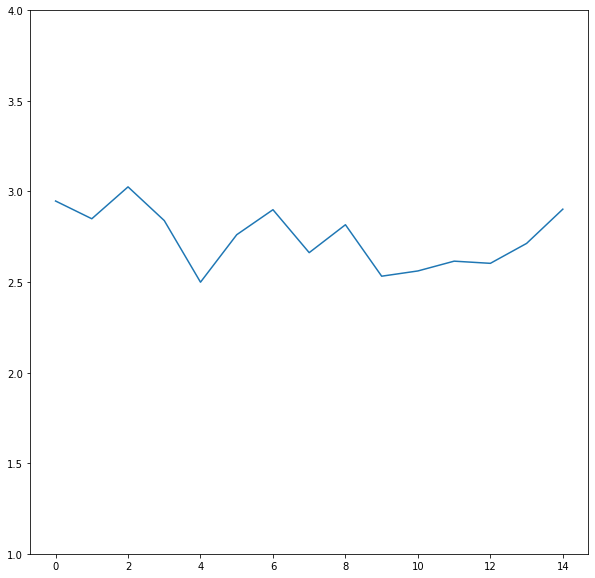

In [272]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.ylim(1,4)
plt.plot(k)


array([2.947, 2.849, 3.025, 2.839, 2.499, 2.761, 2.899, 2.662, 2.816,
       2.532, 2.561, 2.615, 2.603, 2.713, 2.902])

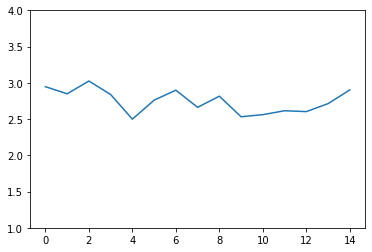

In [273]:
plt.ylim(1,4)
plt.plot(k)
k

In [288]:
collision_counter[10][0]

array([[1.42857143, 0.        , 0.71428571, ..., 2.14285714, 0.        ,
        0.        ],
       [0.71428571, 0.        , 0.        , ..., 0.71428571, 0.        ,
        0.        ],
       [0.        , 0.        , 1.42857143, ..., 1.42857143, 0.        ,
        1.42857143],
       ...,
       [0.        , 0.71428571, 0.        , ..., 0.71428571, 2.14285714,
        0.71428571],
       [1.42857143, 0.71428571, 0.        , ..., 1.42857143, 0.        ,
        0.        ],
       [2.14285714, 0.71428571, 0.71428571, ..., 1.42857143, 0.        ,
        0.        ]])

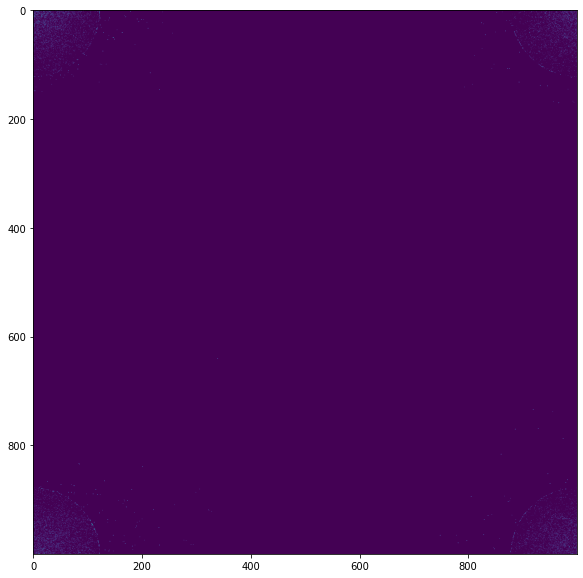

In [285]:
plt.figure(figsize=(10,10))
plt.imshow(collision_counter[0][0][:][:])

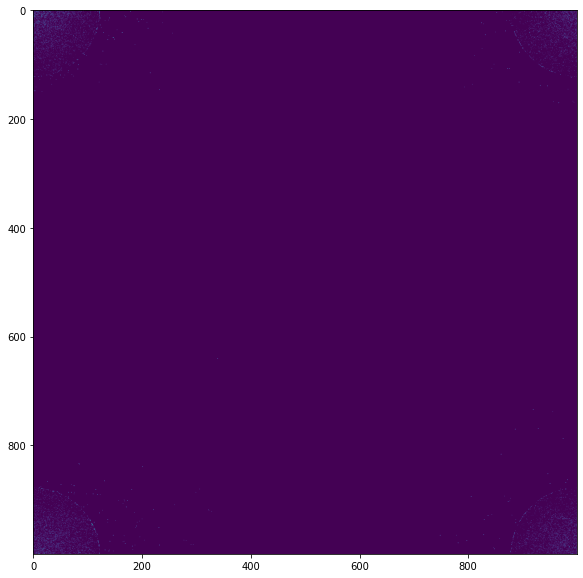

In [287]:
plt.figure(figsize=(10,10))
plt.imshow(collision_counter[0][0][:][:])

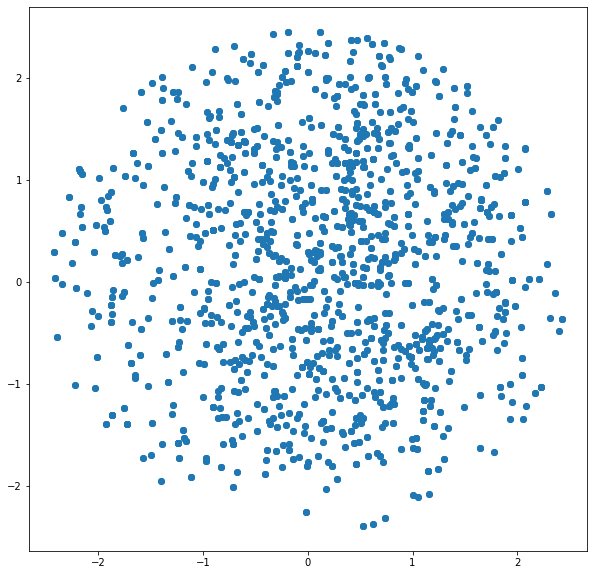

In [277]:
plt.figure(figsize=(10,10))
plt.scatter(record[0],record[1])

<Figure size 432x288 with 0 Axes>

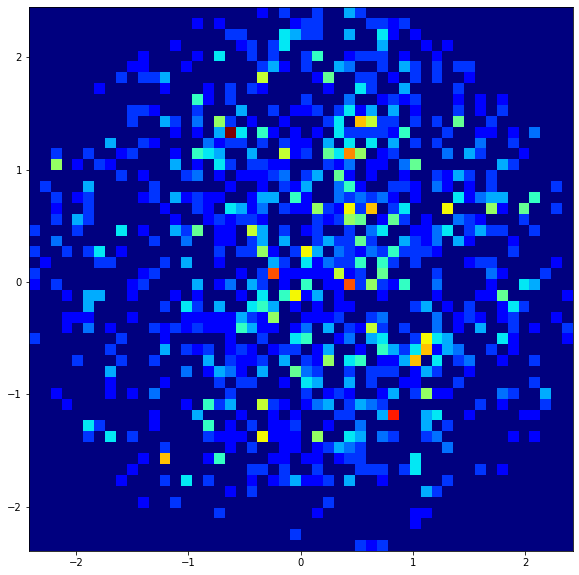

In [278]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Generate some test data
x = record[0]
y = record[1]

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(heatmap.T,cmap=cm.jet, extent=extent, origin='lower')
plt.show()


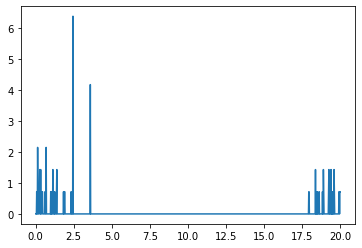

In [284]:
plt.plot(X,collision_counter[9][0][:][1])

In [280]:
len(collision_counter[0][0][:][1]),len(x)

(1000, 2902)